# Opracowanie modelu regresji do przewidzenia liczby pasażerów transportu kolejowego
#### Autorzy: Szymon Kowalski, Zuzanna Czyżowska - zespół 18
## 1. Wprowadzenie

W poprzedniej części projektu, przeprowadziliśmy analizę naszego zbioru i na jej podstawie dokonaliśmy doboru cech do naszego modelu. Cechy zapisaliśmy do nowego pliku .csv, aby łatwo przejść do opracowania modelu regresji.

## 2. Importy i załadowanie danych

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [23]:
tables = pd.read_csv('all_data_after_analyze.csv')

print("Dane:")
print(tables.head())
print("Rozmiar danych:")
print(tables.shape)

Dane:
    n        year  country     pa_tr  pa_tr_na  pa_tr_in     tr_tr  \
0  18  2013-01-01  Austria  235434.0  225063.0   10371.0  134386.0   
1  11  2013-01-01  Croatia   24216.0   23810.0     406.0   16651.0   
2   3  2013-01-01  Czechia  174189.0  170790.0    3399.0  127109.0   
3   4  2013-01-01  Denmark  193500.0  181151.0   12349.0   67045.0   
4   6  2013-01-01  Estonia    4199.0    4077.0     122.0    3337.0   

       le_ra_tr  le_li_hi  le_li_up_hi  ...  n_lo_di  n_ra_di  n_lo_el  ca_ve  \
0   9708.000000       0.0        237.0  ...    464.0    226.0    888.0  269.0   
1   4090.000000       0.0          0.0  ...    159.0    106.0    107.0   33.0   
2  15607.000000       0.0          0.0  ...   1126.0    737.0    770.0  288.0   
3   3613.330147       0.0          0.0  ...     89.0   1088.0     36.0  141.0   
4   2146.000000       0.0          0.0  ...    293.0     46.0      0.0   24.1   

     ex_in    in_in          po  co_pr_le   le_mo    n_pa_air  
0  319.000  211.000   

## 3. Modelowanie regresji

### 1. Podzielenie zbioru na uczący i testowy

In [24]:
X = tables.drop(columns=['n', 'country', 'year', 'pa_tr', 'pa_tr_na', 'pa_tr_in'])
y = tables['pa_tr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Rozmiar zbioru treningowego:", X_train.shape, "\nRozmiar zbioru testowego:", X_test.shape)

Rozmiar zbioru treningowego: (228, 15) 
Rozmiar zbioru testowego: (58, 15)


### 2. Regresja liniowa

Wyniki ewaluacji modelu regresji liniowej:
Mean Absolute Error (MAE): 70970.97737240595
Mean Squared Error (MSE): 9778109818.715616
Root Mean Squared Error (RMSE): 98884.32544501488
R² Score: 0.9829782747137855


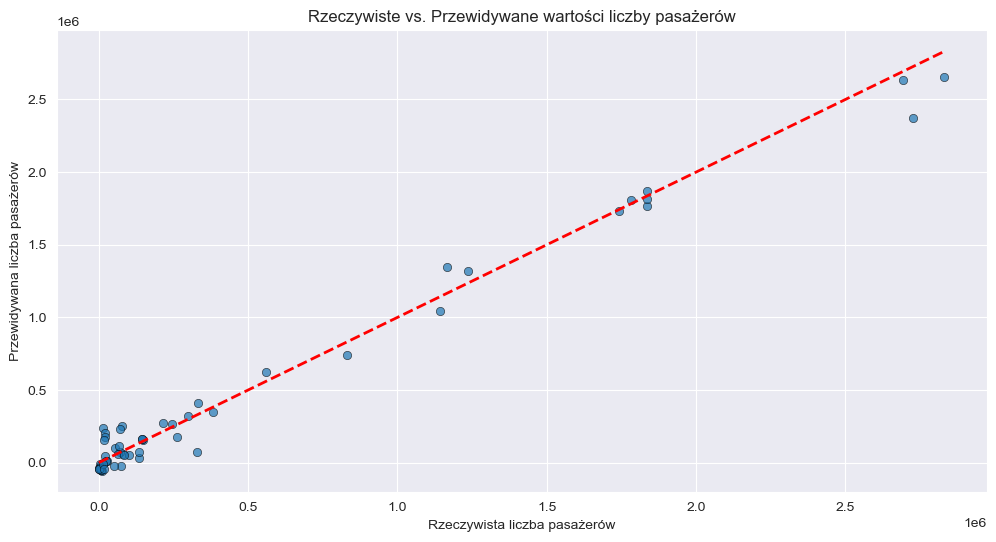

Średni wynik R²: 0.9431773804976764
        Feature  Coefficient
6       n_ra_di   112.404444
9         ex_in    76.283657
13        le_mo    49.818585
4       n_co_tr    41.002134
5       n_lo_di    11.985289
1      le_ra_tr    10.164452
0         tr_tr     0.118819
14     n_pa_air     0.003711
11           po    -0.005029
3   le_li_up_hi    -9.373725
10        in_in   -27.414789
7       n_lo_el   -58.231310
2      le_li_hi  -334.277664
12     co_pr_le  -500.203824
8         ca_ve  -601.158710


In [25]:
#Model regresji liniowej
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

y_pred = model_linear.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Wyniki ewaluacji modelu regresji liniowej:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Porównanie przewidywanych i rzeczywistych wartości
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Rzeczywista liczba pasażerów')
plt.ylabel('Przewidywana liczba pasażerów')
plt.title('Rzeczywiste vs. Przewidywane wartości liczby pasażerów')
plt.show()

scores = cross_val_score(model_linear, X_train, y_train, cv=5, scoring='r2')
print("Średni wynik R²:", scores.mean())

# Wagi cech w modelu
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_linear.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

### 3. Regresja Ridge

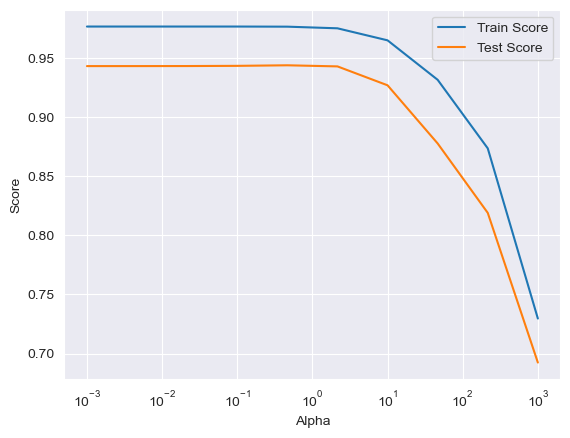

Najlepsza wartość alpha: 0.46415888336127775


In [32]:
#Sprawdzenie dla innych wartości parametru alpha
#Standaryzacja cech
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

param_range = np.logspace(-3, 3, 10)
train_scores, test_scores = validation_curve(
    Ridge(), X_train_scaled, y_train_scaled, param_name="alpha", param_range=param_range, cv=5
)

plt.plot(param_range, train_scores.mean(axis=1), label="Train Score")
plt.plot(param_range, test_scores.mean(axis=1), label="Test Score")
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.legend()
plt.show()

best_alpha_index = np.argmax(test_scores.mean(axis=1))  # Indeks najlepszego alpha na podstawie wyników testowych
best_alpha = param_range[best_alpha_index]
print(f'Najlepsza wartość alpha: {best_alpha}')

Mean Absolute Error (MAE): 0.12712720504282046
Mean Squared Error (MSE): 0.031253444185979085
Root Mean Squared Error (RMSE): 0.17678643665728172
R² Score: 0.9830228099572321
Średni wynik R² z walidacji krzyżowej: 0.9438623070171502
        Feature  Coefficient
14     n_pa_air     0.447445
9         ex_in     0.417918
4       n_co_tr     0.377071
13        le_mo     0.350644
1      le_ra_tr     0.282366
6       n_ra_di     0.091528
0         tr_tr     0.040716
5       n_lo_di     0.016299
12     co_pr_le    -0.026332
3   le_li_up_hi    -0.039266
10        in_in    -0.077794
7       n_lo_el    -0.078306
8         ca_ve    -0.206674
11           po    -0.234944
2      le_li_hi    -0.413704


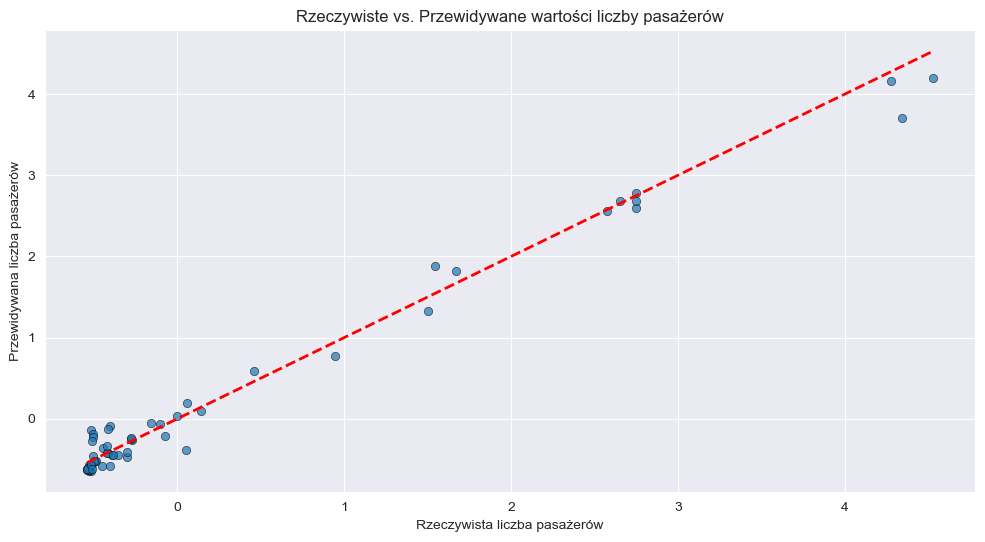

In [34]:
#Model Ridge Regression
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train_scaled, y_train_scaled)

# Prognozy na zbiorze testowym
y_pred_scaled = model_ridge.predict(X_test_scaled)

# Obliczenie metryk
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse = root_mean_squared_error(y_test_scaled, y_pred_scaled)
r2 = r2_score(y_test_scaled, y_pred_scaled)

# Wyświetlenie wyników
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Walidacja krzyżowa
cv_scores = cross_val_score(model_ridge, X_train_scaled, y_train, cv=5, scoring='r2')
print("Średni wynik R² z walidacji krzyżowej:", cv_scores.mean())

# Wagi cech w modelu
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model_ridge.coef_
}).sort_values(by='Coefficient', ascending=False)

print(coefficients)

# Porównanie przewidywanych i rzeczywistych wartości
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test_scaled, y=y_pred_scaled, alpha=0.7, edgecolor='k')
plt.plot([y_test_scaled.min(), y_test_scaled.max()], [y_test_scaled.min(), y_test_scaled.max()], 'r--', lw=2)
plt.xlabel('Rzeczywista liczba pasażerów')
plt.ylabel('Przewidywana liczba pasażerów')
plt.title('Rzeczywiste vs. Przewidywane wartości liczby pasażerów')
plt.show()

### 4. Wizualizacja wyników i ocena modelu

## 4. Regularyzacja modelu

### 1. Implementacja

### 2. Wizualizacja i ocena wyników oraz porównanie przed i po regularyzacji

## 5. Wnioski